Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model saved as random_forest_phishing_model.pkl
Model loaded successfully.
Cross-validation scores: [0.96689569 0.96875    0.965      0.959375   0.96625   ]
Mean cross-validation score: 0.9652541380387258
Confusion Matrix:
 [[1651   64]
 [  51 1663]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1715
           1       0.96      0.97      0.97      1714

    accuracy                           0.97      3429
   macro avg       0.97      0.97      0.97      3429
weighted avg       0.97      0.97      0.97      3429


Accuracy Score: 0.9664625255176437

AUC-ROC Score: 0.9940287666992118


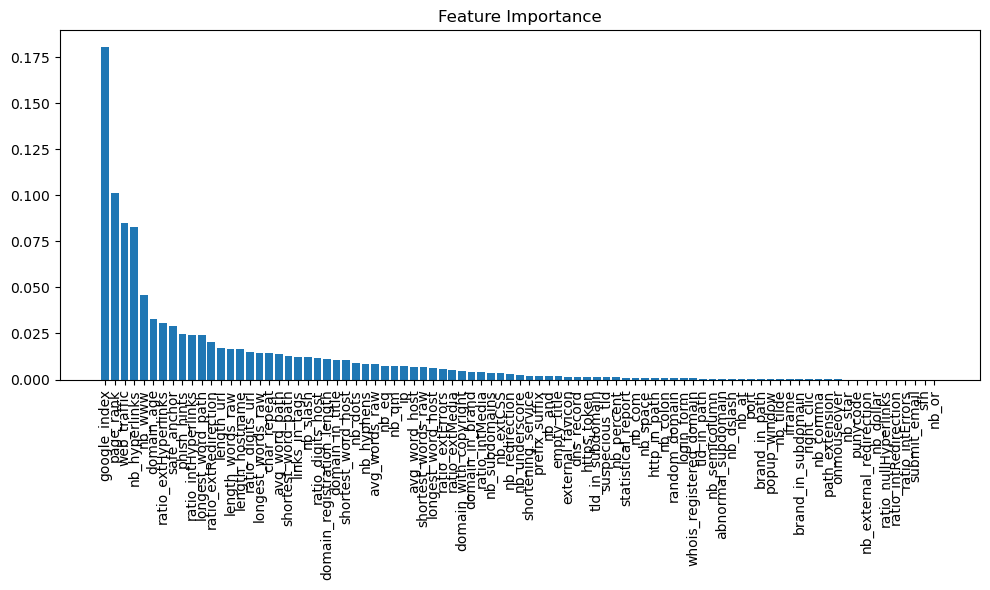

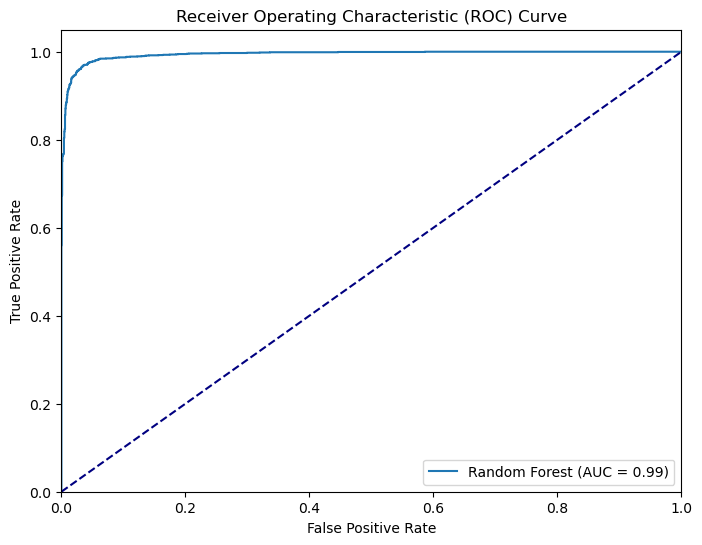

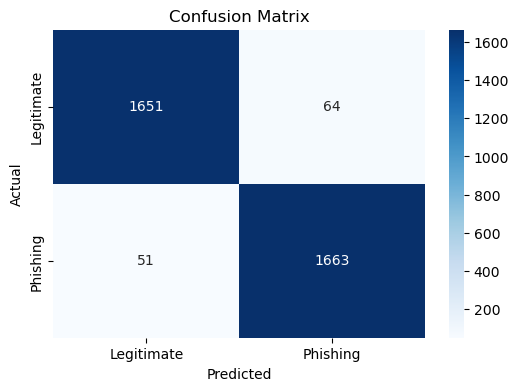

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib  

# Step 1: Load the dataset
file_path = 'dataset_phishing.csv'  
dataset = pd.read_csv(file_path)

# Step 2: Data Preprocessing
label_encoder = LabelEncoder()
dataset['status'] = label_encoder.fit_transform(dataset['status'])

X = dataset.drop(columns=['status', 'url'])
y = dataset['status']

# Step 3: Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 4: Hyperparameter tuning for Random Forest using RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV for hyperparameter tuning
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Best estimator after hyperparameter tuning
best_rf = rf_random.best_estimator_

# Step 5: Save the model
model_filename = 'random_forest_phishing_model.pkl'
joblib.dump(best_rf, model_filename)
print(f"Model saved as {model_filename}")

# Step 6: Load the saved model
loaded_rf = joblib.load(model_filename)
print("Model loaded successfully.")

# Step 7: Model Training and Cross-Validation
cv_scores = cross_val_score(loaded_rf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Step 8: Evaluate on Test Data
y_pred = loaded_rf.predict(X_test)
# For ROC curve and AUC
y_prob = loaded_rf.predict_proba(X_test)[:, 1]  

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Output Evaluation Metrics
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("\nAccuracy Score:", accuracy)
print("\nAUC-ROC Score:", roc_auc)

# Step 9: Feature Importance
importances = loaded_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# Step 10: ROC Curve Visualization
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Step 11: Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
